In [21]:
### Finds the High and Low Dimension:
### 1. Covariance Matrix
### 2. Rank of Matrix
### 2. Eigenvalues and Eigenvectors
### 3. Non-zero and Non-negative Eigenvectors and Eigenvalues
### 4. Compare High- and Low-Dimension Eigenvalues
### 5. Reconstruction, Reconstruction Error, Reconstruction Time
### 6. Recognition, Recognition Time

############################### IMPORT DEPENDENCIES ######################################################

import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
#import cv2
import sys
import time
import os
import psutil
import pandas as pd

from scipy.io import loadmat
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from numpy.linalg import norm
from pandas import DataFrame
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import matrix_rank
from sklearn.metrics import confusion_matrix

										# comment out this code when running on jupyter
dir = os.getcwd()						# gets the working directory of the file this python script is in
os.chdir (dir)							# changes the working directory to the file this python script is in
										# also change plt.savefig to plt.show

############################### FUNCTIONS START HERE ######################################################

def calculate_non_zero_eigenvalues(eigenvalues,name):
	count_non_zero = 0
	count_actual_non_zero = 0
	count_negative = 0
	for i in range(0,len(eigenvalues)):
		if eigenvalues[i]>000000000.1:
			count_non_zero = count_non_zero+1
		if eigenvalues[i]>0:
			count_actual_non_zero = count_actual_non_zero + 1
		if eigenvalues[i]<0:
			count_negative = count_negative + 1
	print("Number of", name, "> 1e-9 =",count_non_zero)
	print("Number of", name, "> 0 =",count_actual_non_zero)
	print("Number of", name, "< 0 =",count_negative,"\n")

def memory_usage_psutil():
    # return the memory usage in MB
    import psutil
    process = psutil.Process(os.getpid())
    mem = process.memory_info()[0] / float(2 ** 20)
    return mem
			
def print_image(face_image):			# function for plotting an image
	face_image = np.reshape(face_image, (46,56))
	face_image = face_image.T
	plt.imshow(face_image, cmap='gist_gray')
	plt.show()

def save_image(face_image,title):		# function for saving an image
	face_image = np.reshape(face_image, (46,56))
	face_image = face_image.T
	plt.imshow(face_image, cmap='gist_gray')
	plt.title(title)
	plt.savefig(title)
	
def partition_data(face_data,face_labels,split):
	number_of_faces = face_data.shape[1]
	number_of_pixels = face_data.shape[0]
	face_labels_array = []
	face_pixels_array = []

	# Create an array that only contains the column pixels of the image
	for i in range (0,number_of_faces):
		face_labels_array.append(face_labels[0,i])					# Array that contains the labels
		face_pixels_array.append(face_data[:,i])					# Array that contrains the face_data
		#print(face_labels_array[i], " = ", face_pixels_array[i])
	
	print(face_labels_array)
	
	x_train = []
	x_test = []
	y_train = []
	y_test = []
	for i in range(0,52):
		i = i*10
		face_array = face_pixels_array[i:i+10]
		labels_array = face_labels_array[i:i+10]
		face_train, face_test, label_train, label_test = train_test_split(face_array, labels_array, test_size=split, random_state=42)
		x_train.extend(face_train)
		y_train.extend(label_train)
		x_test.extend(face_test)
		y_test.extend(label_test)
	print("\n")
	print("Split = ", split, " ---> Train =", 1-split, ", Test =", split)
	print("Size of Train Data (Pixel Vectors): ", 	len(x_train))
	print("Size of Train Data (Labels)", 			len(y_train))
	print("Size of Test Data (Pixel Vectors): ", 	len(x_test))
	print("Size of Test Data (Labels)", 			len(y_test), "\n")
	train_size = len(x_train)
	test_size = len(x_test)
	x_train = np.array(x_train)[np.newaxis]
	x_test = np.array(x_test)[np.newaxis]
	
	return x_train, y_train, x_test, y_test, train_size, test_size

def calculate_mean_image(x_train,train_size):
	sum_of_training_faces = [0]
	for i in range(0,train_size):
		sum_of_training_faces = sum_of_training_faces + x_train[:,i]
	average_training_face = sum_of_training_faces/train_size
	print("Mean Face has shape",average_training_face.shape,":\n",average_training_face, "\n")
	print("x_train has shape",x_train.shape,":\n",x_train, "\n")
	
	return average_training_face	

def calculate_covariance_matrix(x_train,x_test,average_training_face):
	A_train = np.subtract(x_train,average_training_face).squeeze()
	A_test = np.subtract(x_test,average_training_face).squeeze()
	rank_A_train = matrix_rank(A_train)
	rank_A_test = matrix_rank(A_test)
	print("A_train has shape",A_train.shape,"and rank",rank_A_train,":\n",A_train, "\n")
	print("A_test has shape",A_test.shape,"and rank",rank_A_test,":\n",A_test, "\n")
	start_time = time.time()
	high_dimension_covariance_matrix = np.dot(A_train.T,A_train)/train_size
	high_dimension_covariance_matrix_time = time.time() - start_time
	start_time = time.time()
	low_dimension_covariance_matrix = np.dot(A_train,A_train.T)/train_size
	low_dimension_covariance_matrix_time = time.time() - start_time

	rank_S_hd = matrix_rank(high_dimension_covariance_matrix)
	rank_S_ld = matrix_rank(low_dimension_covariance_matrix)
	
	print("High-Dimension Covariance Matrix [",np.round(high_dimension_covariance_matrix_time,3), "s ] has shape",high_dimension_covariance_matrix.shape,"and rank",rank_S_hd,":\n",high_dimension_covariance_matrix, "\n")
	print("Low-Dimension Covariance Matrix [",np.round(low_dimension_covariance_matrix_time,3), "s ] has shape",low_dimension_covariance_matrix.shape,"and rank",rank_S_ld,":\n",low_dimension_covariance_matrix, "\n")

	return A_train, A_test, high_dimension_covariance_matrix, low_dimension_covariance_matrix, high_dimension_covariance_matrix_time, low_dimension_covariance_matrix_time

def calculate_eigenvectors_eigenvalues(covariance_matrix_hd, covariance_matrix_ld):
	start_time = time.time()
	eigenvalues_hd, eigenvectors_hd = eigh(covariance_matrix_hd) 
	eigenvalues_eigenvectors_hd_time = time.time() - start_time
	idx_hd = eigenvalues_hd.argsort()[::-1]
	eigenvalues_hd = eigenvalues_hd[idx_hd]
	eigenvectors_hd = eigenvectors_hd[:,idx_hd]
	start_time = time.time()
	eigenvalues_ld, eigenvectors_ld = eigh(covariance_matrix_ld) 
	eigenvalues_eigenvectors_ld_time = time.time() - start_time
	idx_ld = eigenvalues_ld.argsort()[::-1]
	eigenvalues_ld = eigenvalues_ld[idx_ld]
	eigenvectors_ld = eigenvectors_ld[:,idx_ld]
	V = eigenvectors_ld										# V = matrix of low-dimension eigenvectors
	_U = np.dot(V.T,A_train)								# reconstructed U from low-dimension eigenvectors
	print("High-Dimension Eigenvector = U has shape",eigenvectors_hd.shape,":\n",eigenvectors_hd, "\n")
	print("Low-Dimension Eigenvector = V has shape",eigenvectors_ld.shape,":\n",eigenvectors_ld, "\n")
	
	print("High-Dimension Eigenvalues has shape",eigenvalues_hd.shape,":\n",eigenvalues_hd, "\n")
	print("Low-Dimension Eigenvalues has shape",eigenvalues_ld.shape,":\n",eigenvalues_ld, "\n")
	
	calculate_non_zero_eigenvalues(eigenvalues_hd,"HD Eigenvalues")
	calculate_non_zero_eigenvalues(eigenvalues_ld,"LD Eigenvalues")
	
	
	
	return eigenvalues_hd, eigenvectors_hd, eigenvalues_ld, eigenvectors_ld, V, _U, eigenvalues_eigenvectors_hd_time, eigenvalues_eigenvectors_ld_time
	
def plot_top_M_eigenfaces(eigenvec,M):
	cols = 10
	rows = M/cols
	index = 1
	font_size = 10
	plt.figure(figsize=(20,20))
	for i in range(0,M):
		plt.subplot(rows,cols,index),plt.imshow(np.reshape(eigenvec[:,i],(46,56)).T, cmap = 'gist_gray')
		face_title = str("M="+str(i+1))
		plt.title(face_title, fontsize=font_size).set_position([0.5,0.95]), plt.xticks([]), plt.yticks([])	# set_position([a,b]) adjust b for height
		index = index+1
	overall_title = str("Top "+str(M)+" Eigenfaces for High-Dim PCA")
	plt.suptitle(overall_title)
	plt.show()
	plt.close()

def plot_eigenvalues(eigenvalues_hd, eigenvalues_ld, mode):		# function for plotting high-dimension and low-dimension eigenvalues
	df_hd = DataFrame(eigenvalues_hd, columns = ['High-Dimension Eigenvalues'])	# converting high-dim array into a dataframe
	df_ld = DataFrame(eigenvalues_ld, columns = ['Low-Dimension Eigenvalues'])	# converting the low-dim array into a dataframe
	hd_eigenvalues = df_hd['High-Dimension Eigenvalues']
	ld_eigenvalues = df_ld['Low-Dimension Eigenvalues']
	
	if mode == 'plot':
		plt.figure(figsize=(8,8))
		#plt.scatter(df_hd.index.values, hd_eigenvalues, color = 'red', s=50, alpha=1, marker = 'o')	# creating a scatter plot for the high-dim eigenvalues
		#plt.scatter(df_ld.index.values, ld_eigenvalues, color = 'blue', s=50, alpha=1, marker = 'x')	# creating a scatter plot for the low-dim eigenvalues
		plt.plot(df_hd.index.values, hd_eigenvalues, color = 'red')									# creating line graph for high-dim eigenvalues
		plt.plot(df_ld.index.values, ld_eigenvalues, color = 'blue')									# creating line graph for lower-dim eigenvalues

		plt.grid(color = 'black', linestyle = '-', linewidth = 0.1)							# parameters for plot grid
		plt.xticks(np.arange(min(df_hd.index.values),max(df_hd.index.values)+250, 250))							# adjusting the intervals to 250
		#plt.yticks(np.arange(min(hd_eigenvalues),max(hd_eigenvalues)+25000, 50000))			# adjusting the intervals to 50,000
		plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))						# setting y-axis to scientific scale
		plt.title('Comparing High-Dimension and Low-Dimension PCA Eigenvalues')

		plt.xlabel('Eigenvalue Index (M)')
		plt.ylabel('Eigenvalue')			
		plt.legend(loc = 'upper right')														# creating legend and placing in at the top right
		plt.show()	
		
	return df_hd, df_ld
	
def reconstruct_image_LD_PCA(X_train,Y_train,A,eigenvectors,sample_list,M_list,average_training_face,main_title,mode):
	if mode == 'time':
		sample_list = [0]
		M_list = [10,20,30,40,50,60,70,80,90,100,200,300,400,415,416]
	if mode == 'error':
		sample_list = [0]
		M_list = [10,20,30,40,50,60,70,80,90,100,200,300,400,415,416]
	index = 1
	font_size = 10
	count = 1
	cols = len(M_list)
	rows = len(sample_list)
	plt.figure(figsize=(20,10))
	for sample in sample_list:
		M_time_list = []
		reconstruction_time_list = []
		reconstruction_error_list = []
		original_face = X_train[sample]		
		original_face = np.array(original_face)[np.newaxis]
		plt.subplot(rows+1,cols+1,index), plt.imshow(np.reshape(original_face,(46,56)).T, cmap = 'gist_gray')
		title = str("F"+str(Y_train[sample])+"-Original")
		plt.title(title, fontsize=font_size).set_position([0.5,0.95]), plt.xticks([]), plt.yticks([])
		index=index+1
		for M in M_list:
			start_time = time.time()
			__U = normalize(_U,axis=1,norm='l2')
			__U = np.multiply(__U,-1)
			__U = __U[0:M]
			W = np.dot(A,__U.T)	
			reconstructed_image = average_training_face
			for i in range(0,M):
				print(main_title, ": F",Y_train[sample], "[", count, "/", rows, "] with M =", M, "... ( M = ", i+1, "/", M, ")    ", end="\r")
				au = W[sample,i]*__U[i]
				reconstructed_image = reconstructed_image + au
			reconstruction_time = time.time() - start_time	
			M_time_list.append(M)
			#reconstructed_image = np.array([round(x) for x in reconstructed_image.squeeze()])
			reconstructed_image = np.array([int(x) for x in reconstructed_image.squeeze()])
			reconstruction_error = np.subtract(original_face,reconstructed_image)
			reconstruction_error = norm(reconstruction_error)/norm(original_face)*100
			reconstruction_error_list.append(reconstruction_error)
			reconstruction_time_list.append(reconstruction_time)
			title = str("F"+str(Y_train[sample])+" [M=" + str(M) + "]")
			plt.subplot(rows+1,cols+1,index), plt.imshow(np.reshape(reconstructed_image,(46,56)).T, cmap = 'gist_gray')
			plt.title(title, fontsize=font_size).set_position([0.5,0.95]), plt.xticks([]), plt.yticks([])
			index = index+1
		count = count+1
	if mode == 'time':
		time_df_ld = DataFrame(M_time_list, columns = ['M'])	# converting high-dim array into a dataframe
		time_df_ld['Reconstruction Time(LD)'] = reconstruction_time_list
		reconstruction_df_ld = None
	elif mode == 'error':
		reconstruction_df_ld = DataFrame(M_time_list, columns = ['M'])	
		reconstruction_df_ld['Reconstruction Error(LD)'] = reconstruction_error_list
		time_df_ld = None
	else:
		time_df_ld = None
		reconstruction_df_ld = None
	plt.suptitle(main_title)
	if mode == 'save':
		plt.savefig(main_title)
	if mode == 'show':
		plt.show()
	plt.close()
	
	return time_df_ld, reconstruction_df_ld
	
def reconstruct_image_HD_PCA(X_train,Y_train,A,eigenvectors,sample_list,M_list,average_training_face,main_title,mode):
	if mode == 'time':
		sample_list = [0]
		M_list = [10,20,30,40,50,60,70,80,90,100,200,300,400,415,416,500,600,700,800,900,1000,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2576]
	if mode == 'error':
		sample_list = [0]
		M_list = [10,20,30,40,50,60,70,80,90,100,200,300,400,415,416,500,600,700,800,900,1000,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2576]
	index = 1
	font_size = 8
	count = 1
	cols = len(M_list)
	rows = len(sample_list)
	plt.figure(figsize=(20,10))
	for sample in sample_list:
		M_time_list = []
		reconstruction_time_list = []
		reconstruction_error_list = []
		original_face = X_train[sample]		
		original_face = np.array(original_face)[np.newaxis]
		plt.subplot(rows+1,cols+1,index), plt.imshow(np.reshape(original_face,(46,56)).T, cmap = 'gist_gray')
		title = str("F"+str(Y_train[sample])+"-Original")
		plt.title(title, fontsize=font_size).set_position([0.5,0.95]), plt.xticks([]), plt.yticks([])
		index=index+1
		for M in M_list:
			start_time = time.time()
			U = eigenvectors_hd.T[0:M]
			W = np.dot(A,U.T)	
			reconstructed_image = average_training_face
			for i in range(0,M):
				print(main_title, ": F",Y_train[sample], "[", count, "/", rows, "] with M =", M, "... ( M = ", i+1, "/", M, ")    ", end="\r")
				au = W[sample,i]*U[i]
				reconstructed_image = reconstructed_image + au
			reconstruction_time = time.time() - start_time	
			M_time_list.append(M)
			#reconstructed_image = np.array([round(x) for x in reconstructed_image.squeeze()])
			reconstructed_image = np.array([int(x) for x in reconstructed_image.squeeze()])
			reconstruction_error = np.subtract(original_face,reconstructed_image)
			reconstruction_error = norm(reconstruction_error)/norm(original_face)*100
			reconstruction_error_list.append(reconstruction_error)
			reconstruction_time_list.append(reconstruction_time)
			title = str("F"+str(Y_train[sample])+" [M=" + str(M) + "]")
			plt.subplot(rows+1,cols+1,index), plt.imshow(np.reshape(reconstructed_image,(46,56)).T, cmap = 'gist_gray')
			plt.title(title, fontsize=font_size).set_position([0.5,0.95]), plt.xticks([]), plt.yticks([])
			index = index+1
		count = count+1

	if mode == 'time':
		time_df_hd = DataFrame(M_time_list, columns = ['M'])	
		time_df_hd['Reconstruction Time(HD)'] = reconstruction_time_list
		reconstruction_df_hd = None
	elif mode == 'error':
		reconstruction_df_hd = DataFrame(M_time_list, columns = ['M'])	
		reconstruction_df_hd['Reconstruction Error(HD)'] = reconstruction_error_list
		time_df_hd = None
	else:
		time_df_hd = None
		reconstruction_df_hd = None
	plt.suptitle(main_title)
	if mode == 'save':
		plt.savefig(main_title)
	if mode == 'show':
		plt.show()
	plt.close()
	
	return time_df_hd, reconstruction_df_hd

def plot_time(df_time_hd, df_time_ld,mode):									# function for plotting high-dimension and low-dimension eigenvalues
	time_hd = df_time_hd['Reconstruction Time(HD)']
	M_hd = df_time_hd['M']
	time_ld = df_time_ld['Reconstruction Time(LD)']
	M_ld = df_time_ld['M']

	plt.figure(figsize=(8,8))
	plt.plot(M_hd, time_hd, color = 'red')									
	plt.plot(M_ld, time_ld, color = 'blue')									
	plt.grid(color = 'black', linestyle = '-', linewidth = 0.1)				# parameters for plot grid
	plt.xticks(np.arange(0,max(M_hd)+50, 250))								# adjusting the intervals to 250
	plt.title('Comparing High-Dimension and Low-Dimension PCA Reconstruction Time').set_position([0.5,1.05])
	plt.xlabel('M')
	plt.ylabel('Time Taken(s)')			
	plt.legend(loc = 'upper left')											# creating legend and placing in at the top right
	if mode == 'save':
		plt.savefig('Comparing High-Dimension and Low-Dimension PCA Reconstruction Time')
	if mode == 'show':
		plt.show()
	plt.close()
	plt.figure(figsize=(8,8))
	plt.plot(M_hd, time_hd, color = 'red')									
	plt.plot(M_ld, time_ld, color = 'blue')									
	plt.grid(color = 'black', linestyle = '-', linewidth = 0.1)				# parameters for plot grid
	plt.xticks(np.arange(0,max(M_hd)+50, 250))								# adjusting the intervals to 250
	plt.title('Comparing High-Dimension and Low-Dimension PCA Reconstruction Time').set_position([0.5,1.05])
	plt.xlabel('M')
	plt.ylabel('Time Taken(s)')			
	plt.legend(loc = 'upper left')											# creating legend and placing in at the top right
	plt.xticks(np.arange(0,max(M_hd), 50))
	plt.xlim([0,416])	
	plt.ylim([0,0.05])	

	if mode == 'save':
		plt.savefig('Comparing High-Dimension and Low-Dimension PCA Reconstruction Time (Zoomed to M=416)')
	if mode == 'show':
		plt.show()
	plt.close()

def plot_reconstruction_error(df_time_hd, df_time_ld,mode):									# function for plotting high-dimension and low-dimension eigenvalues
	time_hd = df_time_hd['Reconstruction Error(HD)']
	M_hd = df_time_hd['M']
	time_ld = df_time_ld['Reconstruction Error(LD)']
	M_ld = df_time_ld['M']

	plt.figure(figsize=(8,8))
	plt.plot(M_hd, time_hd, color = 'red')									
	plt.plot(M_ld, time_ld, color = 'blue')									
	plt.grid(color = 'black', linestyle = '-', linewidth = 0.1)				# parameters for plot grid
	plt.xticks(np.arange(0,max(M_hd)+50, 250))								# adjusting the intervals to 250
	plt.yticks(np.arange(0,max(time_hd)+2, 1))
	plt.title('Comparing High-Dimension and Low-Dimension Reconstruction Error').set_position([0.5,1.05])
	plt.xlabel('M')
	plt.ylabel('Reconstruction Error(%)')			
	plt.legend(loc = 'upper right')											# creating legend and placing in at the top right
	if mode == 'save':
		plt.savefig('Comparing High-Dimension and Low-Dimension Reconstruction Error')
	if mode == 'show':
		plt.show()
	plt.close()
	plt.figure(figsize=(8,8))
	plt.plot(M_hd, time_hd, color = 'red')									
	plt.plot(M_ld, time_ld, color = 'blue')									
	plt.grid(color = 'black', linestyle = '-', linewidth = 0.1)				# parameters for plot grid
	plt.xticks(np.arange(0,max(M_hd)+50, 250))								# adjusting the intervals to 250
	plt.title('Comparing High-Dimension and Low-Dimension PCA Reconstruction Time').set_position([0.5,1.05])
	plt.xlabel('M')
	plt.ylabel('Reconstruction Error(%)')			
	plt.legend(loc = 'upper right')											# creating legend and placing in at the top right
	plt.xticks(np.arange(0,max(M_hd), 50))
	plt.yticks(np.arange(0,max(time_hd)+2, 1))
	plt.xlim([0,416])		

	if mode == 'save':
		plt.savefig('Comparing High-Dimension and Low-Dimension PCA Reconstruction Time (Zoomed to M=416)')
	if mode == 'show':
		plt.show()
	plt.close()

def LD_NN_classifier(M_list_NN,A_train,A_test,Y_train,Y_test,eigenvectors_hd,mode,save):
	if mode == 'plot time':
		M_list = [10,20,30,40,50,60,70,80,90,100,200,300,400,415,416]
	if mode == 'success':
		M_list_NN = [30,60,90,416]
	if mode == 'fail':
		M_list_NN = [30,60,90,416]
	success_rate_list = []
	success_rate_M_list = []
	M_time_list = []
	recognition_time_list = []
	mem_psutil = []
	previous = 0
	success_rate_list.append(0)
	success_rate_M_list.append(0)
	for M in M_list_NN:
	#for M in range(0,416,10):
		y_predicted = np.zeros(test_size)
		start_time = time.time()
		success = 0
		_U = np.dot(V.T,A_train)
		__U = normalize(_U,axis=1,norm='l2')
		__U = np.multiply(__U,-1)
		__U = __U[0:M]
		W_train = np.dot(A_train,__U.T)	
		W_test = np.dot(A_test,__U.T)
		
		for ntest in range(0,test_size):
			minimum_error = 999999999
			start_time = time.time()
			for ntrain in range(0,train_size):
				error =  W_test[ntest]-W_train[ntrain]
				l2_error = norm(error)
				if l2_error<minimum_error:
					minimum_error = l2_error
					label = Y_train[ntrain]
					pos = ntrain
					y_predicted[ntest] = label    ##forming array of predicted labels from classifier
			if Y_test[ntest] == label:
				success = success + 1
				font_size=10
				if mode == 'success':
					index1=1
					index2=0
					index3=0
					plt.figure(figsize=(20,10))
					for M in M_list_NN:
						_U = np.dot(V.T,A_train)
						__U = normalize(_U,axis=1,norm='l2')
						__U = np.multiply(__U,-1)
						__U = __U[0:M]
						W_train = np.dot(A_train,__U.T)	
						W_test = np.dot(A_test,__U.T)
						font_size = 10
						reconstructed_train_image = average_training_face
						reconstructed_test_image = average_training_face
						for i in range(0,M):
							au_train = W_train[pos,i]*__U[i]
							au_test = W_test[ntest,i]*__U[i]
							reconstructed_train_image = reconstructed_train_image + au_train
							reconstructed_test_image = reconstructed_test_image + au_test
						title1 = str("Reconstructed Train: F"+str(Y_train[pos])+", M="+str(M))
						title2 = str("Reconstructed Test: F"+str(Y_test[ntest])+", M="+str(M))
						title3 = str("Original Test")
						index2=index1+4
						index3=index1+8
						plt.subplot(3,4,index1), plt.imshow(np.reshape(reconstructed_train_image,(46,56)).T, cmap = 'gist_gray')
						plt.title(title1, fontsize=font_size).set_position([0.5,1.0]), plt.xticks([]), plt.yticks([])
						plt.subplot(3,4,index2), plt.imshow(np.reshape(reconstructed_test_image,(46,56)).T, cmap = 'gist_gray')
						plt.title(title2, fontsize=font_size).set_position([0.5,1.0]), plt.xticks([]), plt.yticks([])
						plt.subplot(3,4,index3), plt.imshow(np.reshape(np.array(X_test[ntest])[np.newaxis],(46,56)).T, cmap = 'gist_gray')
						plt.title(title3, fontsize=font_size).set_position([0.5,1.0]), plt.xticks([]), plt.yticks([])
						plt.suptitle("Success Example")
						index1 = index1+1
					if save == 'yes':
						file_title = str("Success Example")
						plt.savefig(file_title)
						plt.close()
					else:
						plt.show()
						plt.close()
					mode = 'none'
					
			if Y_test[ntest] != label:
				font_size=10
				if mode == 'fail':
					index1=1
					index2=0
					index3=0
					plt.figure(figsize=(20,10))
					for M in M_list_NN:
						_U = np.dot(V.T,A_train)
						__U = normalize(_U,axis=1,norm='l2')
						__U = np.multiply(__U,-1)
						__U = __U[0:M]
						W_train = np.dot(A_train,__U.T)	
						W_test = np.dot(A_test,__U.T)
						font_size = 10
						reconstructed_train_image = average_training_face
						reconstructed_test_image = average_training_face
						for i in range(0,M):
							au_train = W_train[pos,i]*__U[i]
							au_test = W_test[ntest,i]*__U[i]
							reconstructed_train_image = reconstructed_train_image + au_train
							reconstructed_test_image = reconstructed_test_image + au_test
						title1 = str("Reconstructed Train: F"+str(Y_train[pos])+", M="+str(M))
						title2 = str("Reconstructed Test: F"+str(Y_test[ntest])+", M="+str(M))
						title3 = str("Original Test")
						index2=index1+4
						index3=index1+8
						plt.subplot(3,4,index1), plt.imshow(np.reshape(reconstructed_train_image,(46,56)).T, cmap = 'gist_gray')
						plt.title(title1, fontsize=font_size).set_position([0.5,1.0]), plt.xticks([]), plt.yticks([])
						plt.subplot(3,4,index2), plt.imshow(np.reshape(reconstructed_test_image,(46,56)).T, cmap = 'gist_gray')
						plt.title(title2, fontsize=font_size).set_position([0.5,1.0]), plt.xticks([]), plt.yticks([])
						plt.subplot(3,4,index3), plt.imshow(np.reshape(np.array(X_test[ntest])[np.newaxis],(46,56)).T, cmap = 'gist_gray')
						plt.title(title3, fontsize=font_size).set_position([0.5,1.0]), plt.xticks([]), plt.yticks([])
						plt.suptitle("Fail Example")
						index1 = index1+1
					if save == 'yes':
						file_title = str("Fail Example")
						plt.savefig(file_title)
						plt.close()
					else:
						plt.show()
						plt.close()
					mode = 'none'

			recognition_time = time.time() - start_time	

		success_rate = success/test_size*100
		increase = success_rate - previous
		plot_confusion_matrix(Y_test, y_predicted, M, increase,'yes')
		previous = success_rate
		recognition_time_list.append(recognition_time)
		M_time_list.append(M)
		success_rate_list.append(success_rate)
		success_rate_M_list.append(M)
		recognition_time_list.append(recognition_time)
		mem_psutil.append(memory_usage_psutil())
		if mode == 'print':
			print("For M =",M,"success rate is",success_rate,"% ... increase = ",increase)
	if mode == 'plot mem':
		df = DataFrame(M_time_list, columns = ['M'])	# converting high-dim array into a dataframe
		df['psutil'] = mem_psutil
		x = df['M']
		y = df['psutil']
		plt.figure(figsize=(8,8))
		plt.plot(x,y,color = 'black')
		plt.xticks(np.arange(0,max(x)+50,250))								# adjusting the intervals to 250	
		plt.title('Relationship between M and Memory Usage').set_position([0.5,1.05])
		plt.xlabel('M')
		plt.ylabel('Memoru Usage in MB')			
		plt.grid(color = 'black', linestyle = '-', linewidth = 0.1)		
		plt.legend(loc = 'upper left')											# creating legend and placing in at the top right
		if save == 'yes':
			plt.savefig('Comparing High-Dimension and Low-Dimension PCA Reconstruction Time')
		else:
			plt.show()	
	if mode == 'plot time':
		df = DataFrame(M_time_list, columns = ['M'])	# converting high-dim array into a dataframe
		df['Recognition Time'] = recognition_time_list
		x = df['M']
		y = df['Recognition Time']
		plt.figure(figsize=(8,8))
		plt.plot(x,y,color = 'black')																	
		plt.xticks(np.arange(0,max(x)+50, 250))								# adjusting the intervals to 250
		plt.title('Relationship between M and Recognition Time').set_position([0.5,1.05])
		plt.xlabel('M')
		plt.ylabel('Time Taken(s)')			
		plt.grid(color = 'black', linestyle = '-', linewidth = 0.1)		
		plt.legend(loc = 'upper left')											# creating legend and placing in at the top right
		if save == 'yes':
			plt.savefig('Comparing High-Dimension and Low-Dimension PCA Reconstruction Time')
		else:
			plt.show()		
	if mode == 'plot rate':
		df = DataFrame(success_rate_M_list, columns = ['M'])	# converting high-dim array into a dataframe
		df['Success Rate'] = success_rate_list
		x = df['M']
		y = df['Success Rate']
		
		fig,ax1 = plt.subplots()
		ax2 = ax1.twinx()
		ax1.plot(x,y,color = 'red')
		ax2.plot(df_hd.index.values,df_hd['High-Dimension Eigenvalues'], color = 'green')
		ax1.set_xlabel('M')
		ax1.set_ylim([0,1.01*max(y)])
		ax2.set_ylim([0,1.01*max(df_hd['High-Dimension Eigenvalues'])])
		ax1.set_xlim([-10,100])
		ax1.grid()
		ax1.set_ylabel('Success Rate(%)',color='red')
		ax2.set_ylabel('Eigenvalues',color='green')	
		plt.suptitle('Comparing Top Eigenvalues and Success Rate against M')
		if save == 'yes':
			plt.savefig('Comparing Top Eigenvalues and Success Rate against M')
		else:
			plt.show()
		plt.close()
		
		plt.figure(figsize=(8,8))
		plt.scatter(x, y, color = 'red', s=50, alpha=1, marker = 'x')	# creating a scatter plot for the high-dim eigenvalues
		plt.plot(x,y, color = 'black')									# creating line graph for high-dim eigenvalues
		plt.grid(color = 'black', linestyle = '-', linewidth = 0.1)							# parameters for plot grid
		plt.xticks(np.arange(0,max(x)+250, 250))							# adjusting the intervals to 250
		plt.yticks(np.arange(0,100, 10))			# adjusting the intervals to 50,000
		plt.title('Relationship between M and Success Rate')
		plt.xlabel('M)')
		plt.ylabel('Success Rate (%)')			
		plt.legend(loc = 'upper right')														# creating legend and placing in at the top right
		if save == 'yes':
			plt.savefig('Relationship between M and Success Rate')
		else:
			plt.show()
		plt.close()

In [22]:
def plot_confusion_matrix(y_true, y_predicted, M, increase, show):
    cm = confusion_matrix(y_true, y_predicted)
    #print(cm)
   
    if (show == 'yes' and increase == 0.0):
        plt.matshow(cm, cmap = 'Reds')
        title = 'confusion matrix with ' + str(M) 
        title = title + ' eigenfaces'
        plt.colorbar()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.suptitle(title)
        plt.savefig(title)
        true_positives = 0
        plt.show()
        for i in range (0, 52):
            for j in range (0, 52):
                if(i == j):
                    true_positives += cm[i,j]
        print('\n')
        print('M = ', M, ', number of true positives = ', true_positives, '\n')
        plt.close()
                            
        
       
            
    
    



Showing contents of the .mat file:
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Sat May 27 02:07:24 2006', '__version__': '1.0', '__globals__': [], 'X': array([[106, 130, 191, ...,  70, 183,  77],
       [103, 129, 185, ...,  62, 250,  72],
       [103, 130, 174, ...,  83, 163,  68],
       ...,
       [ 37,  40,  22, ...,  87, 102,  93],
       [ 36,  36,  19, ...,  89,  95, 103],
       [ 41,  35,  17, ...,  94, 106, 110]], dtype=uint8), 'l': array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
        12, 12, 12, 12,

For M = 85 success rate is 66.34615384615384 % ... increase =  66.34615384615384




M =  86 , number of true positives =  69 

For M = 86 success rate is 66.34615384615384 % ... increase =  0.0




M =  87 , number of true positives =  69 

For M = 87 success rate is 66.34615384615384 % ... increase =  0.0


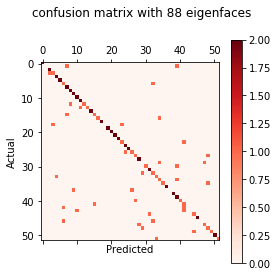



M =  88 , number of true positives =  69 

For M = 88 success rate is 66.34615384615384 % ... increase =  0.0




M =  89 , number of true positives =  69 

For M = 89 success rate is 66.34615384615384 % ... increase =  0.0




M =  90 , number of true positives =  69 

For M = 90 success rate is 66.34615384615384 % ... increase =  0.0




M =  91 , number of true positives =  69 

For M = 91 success rate is 66.34615384615384 % ... increase =  0.0


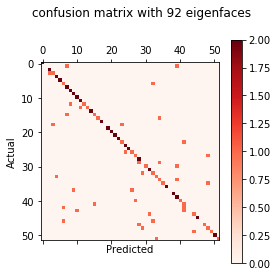



M =  92 , number of true positives =  69 

For M = 92 success rate is 66.34615384615384 % ... increase =  0.0


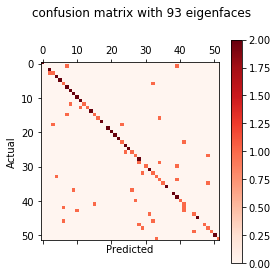



M =  93 , number of true positives =  69 

For M = 93 success rate is 66.34615384615384 % ... increase =  0.0


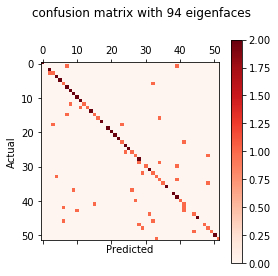



M =  94 , number of true positives =  69 

For M = 94 success rate is 66.34615384615384 % ... increase =  0.0


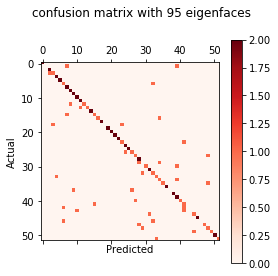



M =  95 , number of true positives =  69 

For M = 95 success rate is 66.34615384615384 % ... increase =  0.0


In [23]:
		
######################################### MAIN STARTS HERE ###########################################################	
	
mat_content = loadmat('face.mat')			# unpacks the .mat file
print("\n")
print("Showing contents of the .mat file:")		# shows the contents of the .mat file
print(mat_content)

face_data = mat_content['X']
face_labels = mat_content['l']	

split = 0.2
x_train, y_train, x_test, y_test, train_size, test_size = partition_data(face_data,face_labels,split)
X_train = x_train.squeeze()				# This is the matrix that contains all of the face training data
X_test = x_test.squeeze()		
Y_train = y_train						# This is the matrix that contains all of the labels for the training data
Y_test = y_test						

#### CALCULATE AVERAGE TRAINING FACE
average_training_face = calculate_mean_image(x_train,train_size)

#### SHOW/SAVE AVERAGE TRAINING FACE
#print_image(average_training_face)
#save_image(average_training_face,"Average Training Face")

#### CALCULATE A AND COVARIANCE MATRICES	
A_train,A_test,high_dimension_covariance_matrix,low_dimension_covariance_matrix, high_dimension_covariance_matrix_time, low_dimension_covariance_matrix_time = calculate_covariance_matrix(x_train,x_test,average_training_face)
covariance_matrix_hd = high_dimension_covariance_matrix ##
covariance_matrix_ld = low_dimension_covariance_matrix	##

#### CALCULATE EIGENVECTORS AND EIGENVALUES 
eigenvalues_hd, eigenvectors_hd, eigenvalues_ld, eigenvectors_ld, V, _U, eigenvalues_eigenvectors_hd_time, eigenvalues_eigenvectors_ld_time = calculate_eigenvectors_eigenvalues(covariance_matrix_hd, covariance_matrix_ld)

#### PLOT TOP M EIGENVECTORS/EIGENFACES
#plot_top_M_eigenfaces(eigenvectors_hd,M=50)

#### PLOT AND COMPARE HIGH- AND LOW-DIMENSION EIGENVALUES
df_hd, df_ld = plot_eigenvalues(eigenvalues_hd, eigenvalues_ld,mode='none')			# mode='plot'/'none'

#### PCA RECONSTRUCTION: HIGH- AND LOW-DIMENSION
M_list_ld = [10,20,30,40,50,60,70,80,90,100,200,300,400,416]						# list that contains values of M to try for LD PCA Reconstruction
M_list_hd = [10,20,30,40,50,60,70,80,90,100,200,300,400,416,1000,1500,2000,2576]	# list that contains values of M to try for HD PCA Reconstruction
sample_list = [0,9,17,25,33,41]														# list of face images to try for PCA Reconstruction
time_df_hd, reconstruction_df_hd = reconstruct_image_HD_PCA(X_train,Y_train,A_train,eigenvectors_hd,sample_list,M_list_hd,average_training_face,"High-Dim PCA Reconstruction", mode='show')		#mode=save/show/time/error
time_df_ld, reconstruction_df_ld = reconstruct_image_LD_PCA(X_train,Y_train,A_train,eigenvectors_ld,sample_list,M_list_ld,average_training_face,"Low-Dim PCA Reconstruction", mode='show')		#mode=save/show/time/error
#plot_time(time_df_hd, time_df_ld,mode='show')										# mode='save'/'show', reconstruct_image_HD/LD_PCA(mode='time')
#plot_reconstruction_error(reconstruction_df_hd, reconstruction_df_ld,mode='show')	# mode='save'/'show', reconstruct_image_HD/LD_PCA(mode='error')

#### NN CLASSIFICATION
M_list_NN = [85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
LD_NN_classifier(M_list_NN,A_train,A_test,Y_train,Y_test,eigenvectors_hd,mode='print',save='no')	# mode='plot time'/'plot rate'/'plot mem'/'print'/'success'/'fail', save=yes/no


